# Denoising Convolutional Autoencoder

In [1]:
import os
from scipy.misc import imread, imresize
import time
import random
import csv
import scipy.io as spio
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.rnn as rnn
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

print("import completed")
print ("TF VERSION %s" % (tf.__version__))

import completed
TF VERSION 1.2.1


Download MNIST dataset

In [2]:
mnist = input_data.read_data_sets('./data/mnist', one_hot=True) # download

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz


In [3]:
train_img = mnist.train.images
tets_img = mnist.test.images

train_label = mnist.train.labels
test_label = mnist.test.labels

val_img = mnist.validation.images
val_label = mnist.validation.labels

# Network Setting

In [4]:
learning_rate = 0.00005
epochs = 15
batch_size = 150

filter_size = 4
drop_rate = 0.8


e1 = 8
e2 = 16
e3 = 32

d1 = 16
d2 = 8
d3 = 1


X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 784])
is_training = tf.placeholder(tf.bool)

In [5]:
def conv_enc(input, maps, f_sz):
    conv_output = tf.layers.conv2d(inputs = input, filters = maps, kernel_size = f_sz, padding = 'SAME'
                                   , activation = tf.nn.relu, kernel_initializer = tf.contrib.layers.xavier_initializer())
    return conv_output
                                   
def conv_dec(input, maps, f_sz):
    conv_output = tf.layers.conv2d_transpose(inputs = input, filters = maps, kernel_size = f_sz, 
                                   padding = 'SAME', activation = tf.nn.relu, 
                                   kernel_initializer = tf.contrib.layers.xavier_initializer())
    return conv_output        

def conv_drop(input, keep_prob, is_training):
    conv_output = tf.layers.dropout(input, keep_prob, is_training)
    return conv_output

# Create Network

In [6]:
def do_cae(_X, is_training):
    _X = tf.reshape(_X, [-1, 28, 28, 1])
    
    with tf.variable_scope('encoder1'):
        enc1 = conv_enc(_X, e1, [filter_size, filter_size])
        enc1 = conv_drop(enc1, drop_rate, is_training)
    
    with tf.variable_scope('encoder2'):
        enc2 = conv_enc(enc1, e2, [filter_size, filter_size])
        enc2 = conv_drop(enc2, drop_rate, is_training)
        
    with tf.variable_scope('encoder3'):
        enc3 = conv_enc(enc2, e3, [filter_size, filter_size])
        enc3 = conv_drop(enc3, drop_rate, is_training)    
        
    with tf.variable_scope('decoder1'):
        dec1 = conv_dec(enc3, d1, [filter_size, filter_size])
        dec1 = conv_drop(dec1, drop_rate, is_training)
        
    with tf.variable_scope('decoder2'):
        dec2 = conv_dec(dec1, d2, [filter_size, filter_size])
        dec2 = conv_drop(dec2, drop_rate, is_training)
    
    with tf.variable_scope('decoder3'):
        dec3 = conv_dec(dec2, d3, [filter_size, filter_size])
        dec3 = conv_drop(dec3, drop_rate, is_training)
        
    
    result = tf.reshape(dec3, [-1, 784])
    
    return {'enc1' : enc1, 'enc2' : enc2, 'enc3' : enc3, 
           'dec1' : dec1, 'dec2' : dec2, 'dec3' : dec3, 
           'result' : result}

print ("CAE Ready!")

CAE Ready!


In [7]:
result_ae = do_cae(X,is_training)

cost = tf.reduce_mean(tf.pow(Y - result_ae['result'],2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Train

training....

Epoch: 0000 cost = 0.036918207

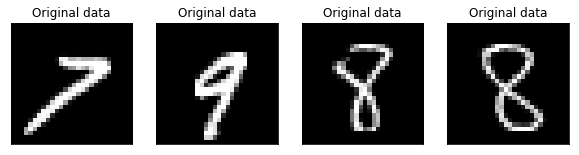

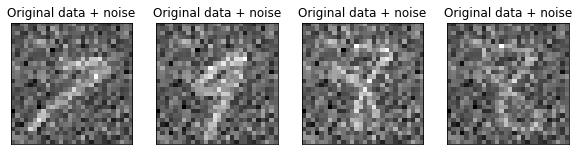

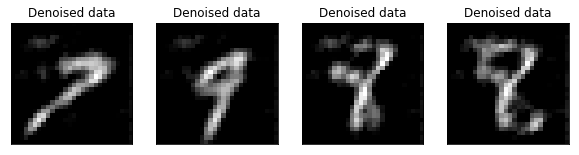


Epoch: 0001 cost = 0.014445880

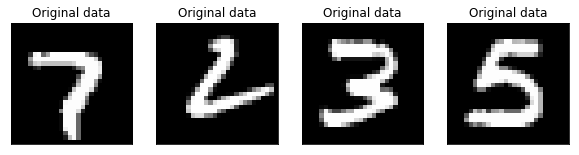

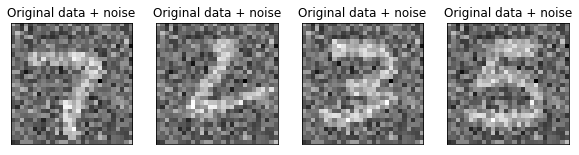

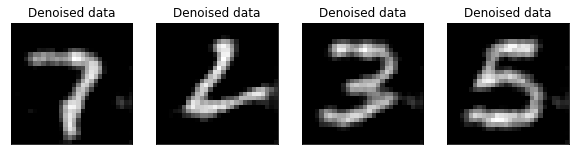


Epoch: 0002 cost = 0.012435528

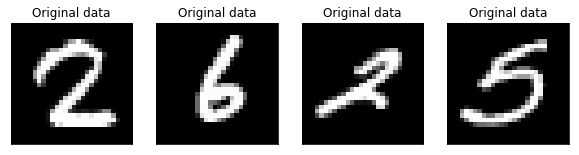

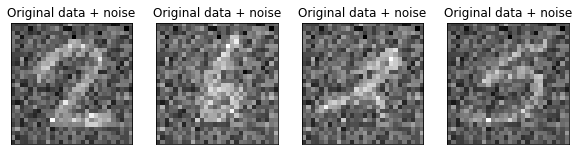

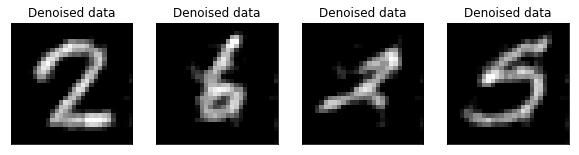


Epoch: 0003 cost = 0.011451646

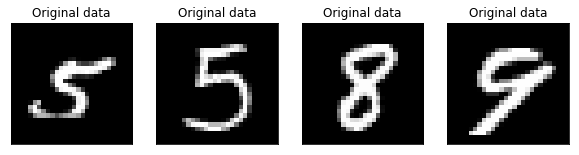

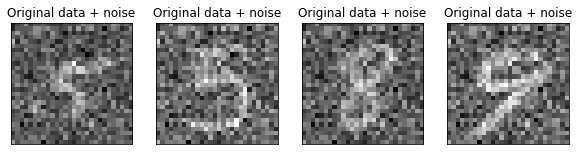

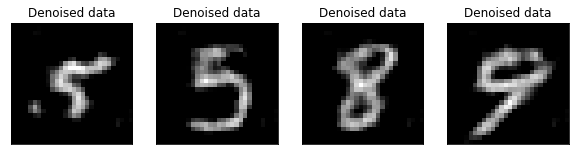


Epoch: 0004 cost = 0.010755160

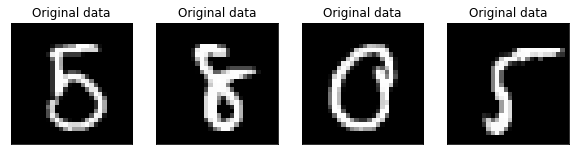

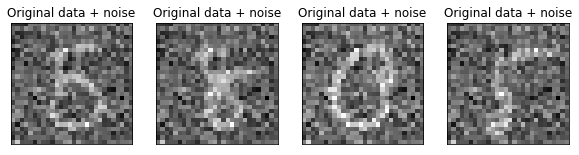

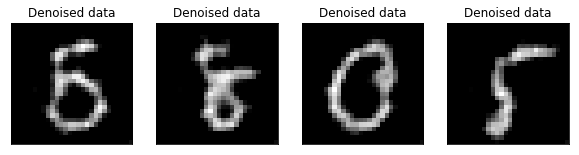


Epoch: 0005 cost = 0.010417490

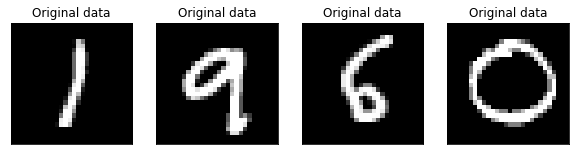

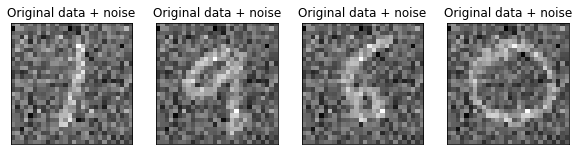

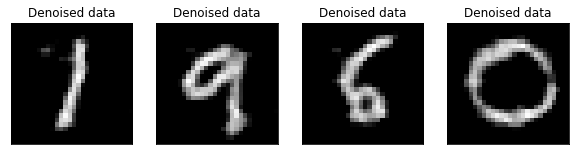


Epoch: 0006 cost = 0.010026201

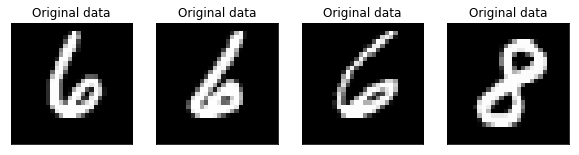

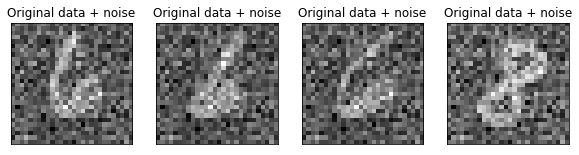

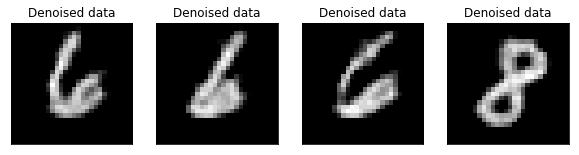


Epoch: 0007 cost = 0.009785704

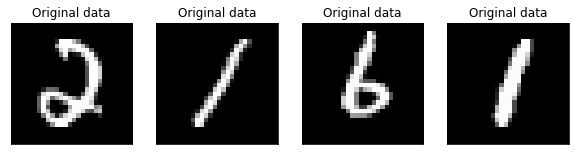

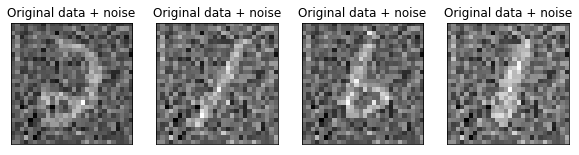

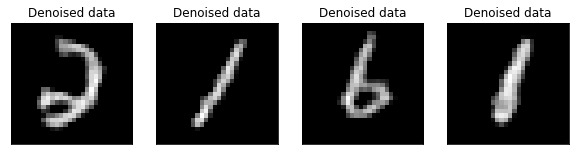


Epoch: 0008 cost = 0.009667728

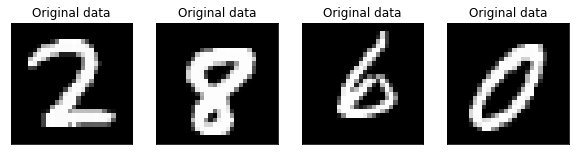

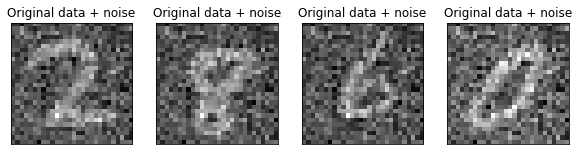

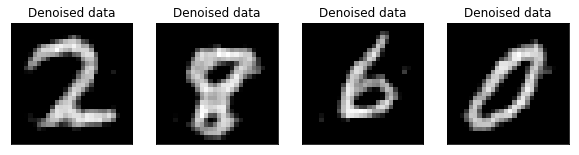


Epoch: 0009 cost = 0.009512669

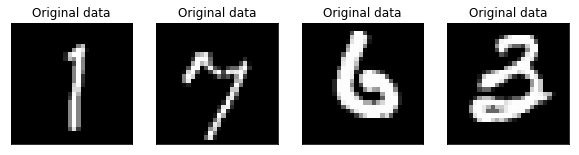

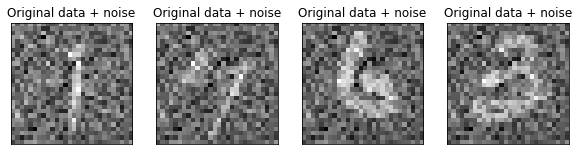

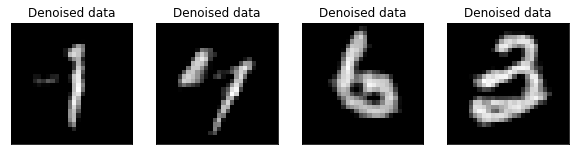


Epoch: 0010 cost = 0.009244702

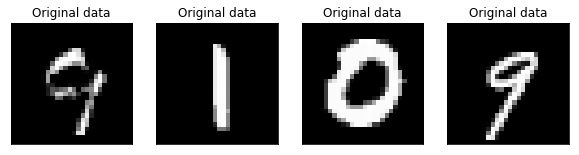

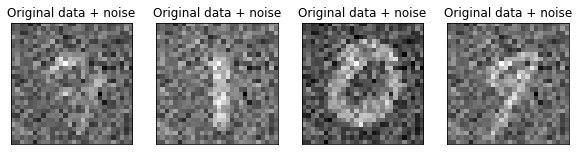

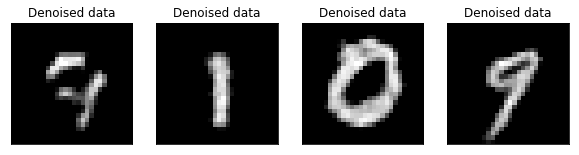


Epoch: 0011 cost = 0.009228089

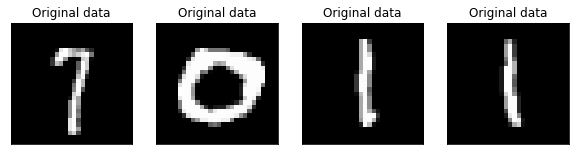

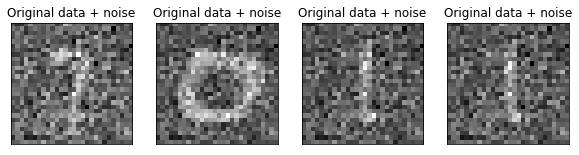

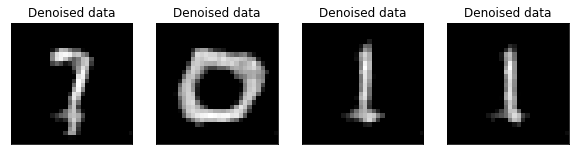


Epoch: 0012 cost = 0.009028447

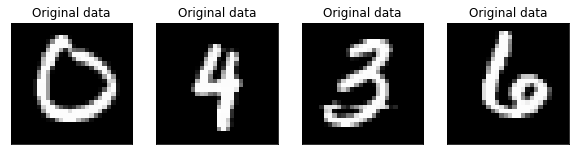

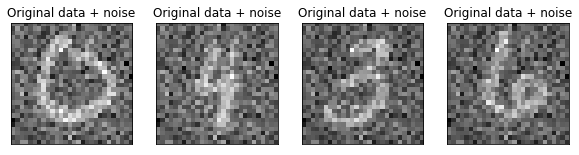

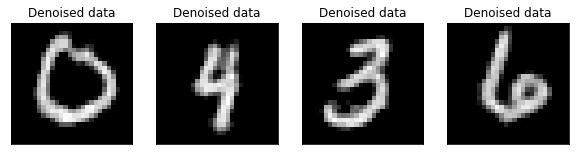


Epoch: 0013 cost = 0.008986043

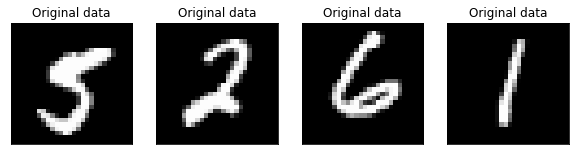

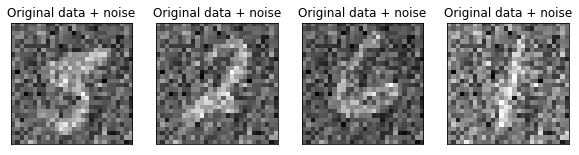

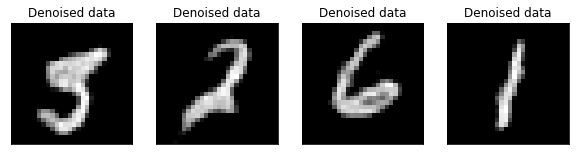


Epoch: 0014 cost = 0.008818127

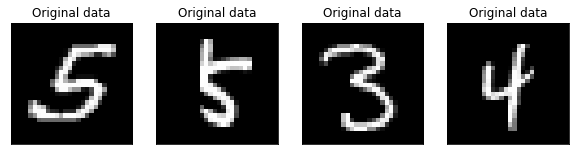

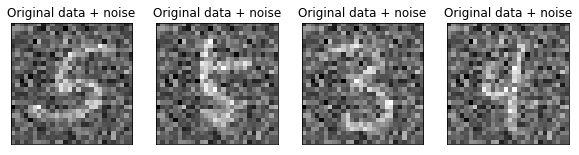

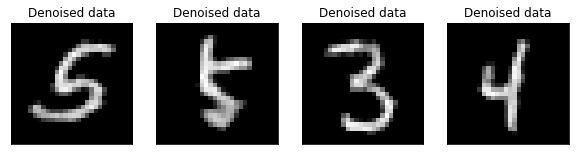


CAE complete
finish!


In [9]:
print('training....')
start_time = time.time()
for epoch in range(epochs):
    avg_cost = 0
    total_batch =  int(mnist.train.num_examples/batch_size)
    for i in range(total_batch):
  
        batch_xs, _ = mnist.train.next_batch(batch_size)
        batch_xs_noise = batch_xs + np.random.randn(784)*0.4
        
        feed_dict = {X: batch_xs_noise,Y: batch_xs, is_training : True}
  
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch        
    
    print('\nEpoch:', '%04d' % (epoch), 'cost =', '{:.9f}'.format(avg_cost), end = '')
    disp_num = 4
    result = sess.run(result_ae['result'], feed_dict = {X: batch_xs_noise[:disp_num], is_training : False})

    fig1= plt.figure(figsize=(10,5))
    for i in range(disp_num):
        snap = fig1.add_subplot(1,disp_num, i+1)
        plt.imshow(batch_xs[i].reshape([28, 28]), cmap = 'gray')
        snap.set_xticks([])
        snap.set_yticks([])
        snap.set_title('Original data')

    fig2= plt.figure(figsize=(10,5))
    for i in range(disp_num):  
        snap = fig2.add_subplot(1,disp_num, i+1)
        plt.imshow(batch_xs_noise[i].reshape([28, 28]), cmap = 'gray')
        snap.set_xticks([])
        snap.set_yticks([])
        snap.set_title('Original data + noise')

    fig3= plt.figure(figsize=(10,5))
    for i in range(disp_num):  
        snap = fig3.add_subplot(1,disp_num, i+1)
        plt.imshow(result[i].reshape([28, 28]), cmap = 'gray')
        snap.set_xticks([])
        snap.set_yticks([])
        snap.set_title('Denoised data')
    plt.show()   
print("\nCAE complete")
end_time = time.time()

print('finish!')

# Test

***Test result***


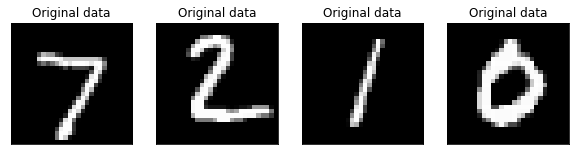

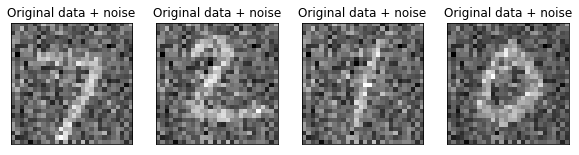

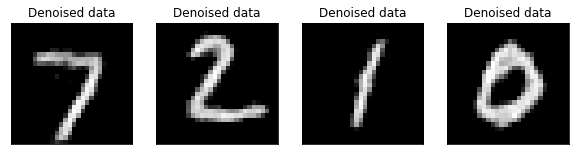

In [10]:
print('***Test result***')

test_sample = mnist.test.images[:4]
test_sample_noise = mnist.test.images[:4] + np.random.randn(784)*0.4
result = sess.run(result_ae['result'], feed_dict = {X: test_sample_noise, is_training : False})

fig1= plt.figure(figsize=(10,5))
for i in range(disp_num):
    snap = fig1.add_subplot(1,disp_num, i+1)
    plt.imshow(test_sample [i].reshape([28, 28]), cmap = 'gray')
    snap.set_xticks([])
    snap.set_yticks([])
    snap.set_title('Original data')
        
fig2= plt.figure(figsize=(10,5))
for i in range(disp_num):  
    snap = fig2.add_subplot(1,disp_num, i+1)
    plt.imshow(test_sample_noise[i].reshape([28, 28]), cmap = 'gray')
    snap.set_xticks([])
    snap.set_yticks([])
    snap.set_title('Original data + noise')

fig3= plt.figure(figsize=(10,5))
for i in range(disp_num):  
    snap = fig3.add_subplot(1,disp_num, i+1)
    plt.imshow(result[i].reshape([28, 28]), cmap = 'gray')
    snap.set_xticks([])
    snap.set_yticks([])
    snap.set_title('Denoised data')
plt.show()